In [1]:
import os
import sv as SV
import numpy as np 
import astropy.table as atable
from tqdm.notebook import tqdm, trange

In [2]:
from desitarget import cuts as desi_cuts

In [3]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.use('Agg')
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
ls_S_dir = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/sweep/9.0'
ls_N_dir = '/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/north/sweep/9.0'

cat_S = atable.Table.read(os.path.join(ls_S_dir, 'sweep-200p005-210p010.fits'))
cat_N = atable.Table.read(os.path.join(ls_N_dir, 'sweep-190p040-200p045.fits'))

In [5]:
cat_S['PHOTSYS'] = 'S'
cat_N['PHOTSYS'] = 'N'

In [6]:
def BGS_quality_mask(targets, south=True):
    ''' apply BGS quality cut and imaging mask
    '''
    photsys_north, photsys_south, obs_rflux, gflux, rflux, zflux,                 \
    w1flux, w2flux, gfiberflux, rfiberflux, zfiberflux,                           \
    gfibertotflux, rfibertotflux, zfibertotflux,                                  \
    objtype, release, ra, dec, gfluxivar, rfluxivar, zfluxivar, w1fluxivar,       \
    gnobs, rnobs, znobs, gfracflux, rfracflux, zfracflux,                         \
    gfracmasked, rfracmasked, zfracmasked,                                        \
    gfracin, rfracin, zfracin, gallmask, rallmask, zallmask,                      \
    gsnr, rsnr, zsnr, w1snr, w2snr, dchisq, deltaChi2, maskbits, refcat = desi_cuts._prepare_optical_wise(objects=targets, mask=True)

    gaia, pmra, pmdec, parallax, parallaxovererror, parallaxerr, gaiagmag, \
    gaiabmag, gaiarmag, gaiaaen, gaiadupsource, Grr, gaiaparamssolved, \
    gaiabprpfactor, gaiasigma5dmax, galb = desi_cuts._prepare_gaia(objects=targets, colnames=None)

    bgs = np.ones_like(gnobs, dtype='?')    
    bgs &= (gnobs >= 1) & (rnobs >= 1) & (znobs >= 1)
    bgs &= (gfluxivar > 0) & (rfluxivar > 0) & (zfluxivar > 0)
    
    # ADM geometric masking cuts from the Legacy Surveys.
    # BRIGHT & CLUSTER for BGS
    bgs &= desi_cuts.imaging_mask(maskbits, bgsmask=True)

    return bgs

In [7]:
qm_S = BGS_quality_mask(cat_S, south=True)
qm_N = BGS_quality_mask(cat_N, south=True)

In [8]:
optw_S = desi_cuts._prepare_optical_wise(objects=cat_S, mask=True)
optw_N = desi_cuts._prepare_optical_wise(objects=cat_N, mask=True)

gaia_S = desi_cuts._prepare_gaia(objects=cat_S, colnames=None)
gaia_N = desi_cuts._prepare_gaia(objects=cat_N, colnames=None)

In [97]:
rfib_S = 22.5 - 2.5 * np.log10(optw_S[9].clip(1e-16))
gmag_S = 22.5 - 2.5 * np.log10(optw_S[3].clip(1e-16))
rmag_S = 22.5 - 2.5 * np.log10(optw_S[4].clip(1e-16))
zmag_S = 22.5 - 2.5 * np.log10(optw_S[5].clip(1e-16))
w1_S = 22.5 - 2.5 * np.log10(optw_S[6].clip(1e-16))

G_rr_S = gaia_S[11]

rfib_N = 22.5 - 2.5 * np.log10(optw_N[9].clip(1e-16))
gmag_N = 22.5 - 2.5 * np.log10(optw_N[3].clip(1e-16))
rmag_N = 22.5 - 2.5 * np.log10(optw_N[4].clip(1e-16))
zmag_N = 22.5 - 2.5 * np.log10(optw_N[5].clip(1e-16))
w1_N = 22.5 - 2.5 * np.log10(optw_N[6].clip(1e-16))

G_rr_N = gaia_N[11]

In [72]:
def BGS_sample(targets, south=True, targtype='bright'):
    ''' apply BGS quality cut and imaging mask
    '''
    photsys_north, photsys_south, obs_rflux, gflux, rflux, zflux,                 \
    w1flux, w2flux, gfiberflux, rfiberflux, zfiberflux,                           \
    gfibertotflux, rfibertotflux, zfibertotflux,                                  \
    objtype, release, ra, dec, gfluxivar, rfluxivar, zfluxivar, w1fluxivar,       \
    gnobs, rnobs, znobs, gfracflux, rfracflux, zfracflux,                         \
    gfracmasked, rfracmasked, zfracmasked,                                        \
    gfracin, rfracin, zfracin, gallmask, rallmask, zallmask,                      \
    gsnr, rsnr, zsnr, w1snr, w2snr, dchisq, deltaChi2, maskbits, refcat = desi_cuts._prepare_optical_wise(objects=targets, mask=True)

    gaia, pmra, pmdec, parallax, parallaxovererror, parallaxerr, gaiagmag, \
    gaiabmag, gaiarmag, gaiaaen, gaiadupsource, Grr, gaiaparamssolved, \
    gaiabprpfactor, gaiasigma5dmax, galb = desi_cuts._prepare_gaia(objects=targets, colnames=None)

    bgs = desi_cuts.isBGS(
            gflux=gflux, rflux=rflux, zflux=zflux, w1flux=w1flux, w2flux=w2flux, rfibertotflux=rfibertotflux,
            rfiberflux=rfiberflux, gnobs=gnobs, rnobs=rnobs, znobs=znobs,
            gfluxivar=gfluxivar, rfluxivar=rfluxivar, zfluxivar=zfluxivar,
            maskbits=maskbits, Grr=Grr, refcat=refcat, w1snr=w1snr, w2snr=w2snr, gaiagmag=gaiagmag,
            objtype=objtype, primary=None, south=south, targtype=targtype)
    return bgs

In [77]:
bgs_bright_S = BGS_sample(cat_S, south=True, targtype='bright')
bgs_bright_N = BGS_sample(cat_N, south=False, targtype='bright')

In [ ]:
bgs_faint_S = BGS_sample(cat_S, south=True, targtype='faint')
bgs_faint_N = BGS_sample(cat_N, south=False, targtype='faint')

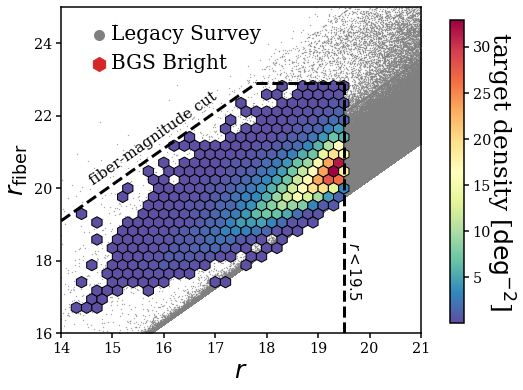

In [107]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

sub.scatter(rmag_S, rfib_S, c='gray', s=0.1, rasterized=True)
sub.scatter(rmag_N, rfib_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='Legacy Survey')

hb = sub.hexbin(rmag_S[bgs_bright_S], rfib_S[bgs_bright_S], C=np.ones(np.sum(bgs_bright_S))/47, edgecolors='k', linewidth=1.,
                reduce_C_function=np.sum, extent=(14, 20, 16, 24), gridsize=30, mincnt=2, cmap='Spectral_r')

sub.scatter([], [], marker='h', s=200, label='BGS Bright', c='C3')

sub.legend(loc='upper left', fontsize=20, handletextpad=-0.4)

sub.text(14.5, 20.1, 'fiber-magnitude cut', rotation=35, fontsize=15)
sub.plot([14, 17.8], [19.1, 22.9], c='k', ls='--', lw=3)
sub.plot([17.8, 19.5], [22.9, 22.9], c='k', ls='--', lw=3)

sub.text(19.55, 17., '$r < 19.5$', rotation=270, fontsize=15)
sub.plot([19.5, 19.5], [16., 22.9], c='k', ls='--', lw=3)

sub.set_xlabel('$r$', fontsize=25)
sub.set_xlim(14, 21)
sub.set_ylabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_ylim(16, 25)
sub.set_yticks([16, 18, 20, 22, 24])

fig.subplots_adjust(wspace=0.1, right=0.75)

cbar_ax = fig.add_axes([0.8, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'target density [${\rm deg}^{-2}$]', labelpad=25, fontsize=25, rotation=270)
fig.savefig('figs/bgs_bright.pdf', bbox_inches='tight')

In [98]:
fibcol_S = (zmag_S - w1_S) - 3/2.5 * (gmag_S - rmag_S) + 1.2
fibcol_N = (zmag_N - w1_N) - 3/2.5 * (gmag_N - rmag_N) + 1.2

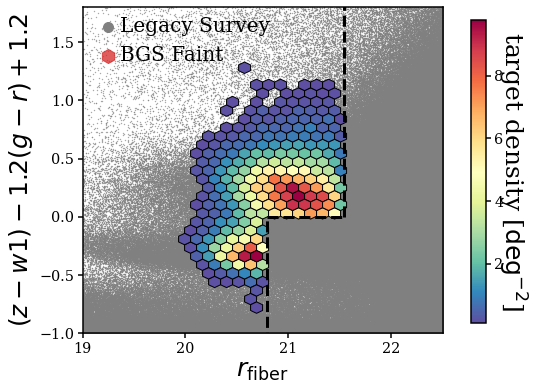

In [126]:
fig = plt.figure(figsize=(8,6))
sub = fig.add_subplot(111)

sub.scatter(rfib_S, fibcol_S, c='gray', s=0.1, rasterized=True)
sub.scatter(rfib_N - 0.04, fibcol_N, c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='Legacy Survey')


hb = sub.hexbin(rfib_S[bgs_faint_S], fibcol_S[bgs_faint_S], C=(np.ones(len(bgs_faint_S))/47).astype(float),
                reduce_C_function=np.sum, extent=(19., 22.5, -1., 1.5), gridsize=30, mincnt=5,
                cmap='Spectral_r', edgecolors='k', linewidth=1.)

sub.scatter([], [], marker='h', s=200, label='BGS Faint', c='C3', alpha=0.75)
#sub.scatter([], [], marker='h', s=200, label='$1\%$', linewidth=3, c='C3', edgecolor='k')

sub.plot([20.79, 20.79], [-2, 0.], c='k', ls='--', lw=3)
sub.plot([20.79, 21.54], [0., 0.], c='k', ls='--', lw=3)
sub.plot([21.54, 21.54], [0., 2.], c='k', ls='--', lw=3)

sub.legend(loc='upper left', bbox_to_anchor=(-0.035, 1.025), fontsize=20, handletextpad=-0.4)

sub.set_ylabel('$(z - w1) - 1.2 (g - r) + 1.2$', fontsize=25)
sub.set_yticks([-1., -0.5, 0., 0.5, 1., 1.5])
sub.set_ylim(-1., 1.8)
sub.set_xlabel(r'$r_{\rm fiber}$', fontsize=25)
sub.set_xlim(19.0, 22.5)
sub.set_xticks([19., 20, 21, 22])

fig.subplots_adjust(wspace=0.1, right=0.75)

cbar_ax = fig.add_axes([0.8, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'target density [${\rm deg}^{-2}$]', labelpad=25, fontsize=25, rotation=270)
fig.savefig('figs/bgs_faint.pdf', bbox_inches='tight')

In [11]:
# load compiled zsuccess rates to file
dat_dir = '/global/cscratch1/sd/chahah/bgs-cmxsv/sv-paper/'
#dat_dir = '/Users/chahah/data/bgs_cmxsv/sv_paper/'

sv1_gals = atable.Table.read(os.path.join(dat_dir, 'sv1.bgs_exps.efftime160_200.zsuccess.fits'))
sv3_gals = atable.Table.read(os.path.join(dat_dir, 'sv3.bgs_exps.efftime160_200.zsuccess.fits'))
main_gals = atable.Table.read(os.path.join(dat_dir, 'main.bgs_exps.efftime160_200.zsuccess.fits'))

In [12]:
from desiutil.dust import ext_odonnell

sv1_gals = sv1_gals[(sv1_gals['PHOTSYS'] != '') & (sv1_gals['PHOTSYS'] != 'G')]
sv3_gals = sv3_gals[sv3_gals['PHOTSYS'] != '']

from speclite import filters
decamwise = filters.load_filters('decam2014-g', 'decam2014-r','decam2014-z', 'wise2010-W1', 'wise2010-W2')
bassmzlswise = filters.load_filters('BASS-g', 'BASS-r', 'MzLS-z','wise2010-W1', 'wise2010-W2')

RV = 3.1

sv1_mw_trans = np.array([10**(-0.4 * sv1_gals['EBV'][i] * RV * ext_odonnell(bassmzlswise.effective_wavelengths.value, Rv=RV)) if sv1_gals['PHOTSYS'][i] == 'N'
                         else 10**(-0.4 * sv1_gals['EBV'][i] * RV * ext_odonnell(decamwise.effective_wavelengths.value, Rv=RV)) for i in range(len(sv1_gals['EBV']))])
sv3_mw_trans = np.array([10**(-0.4 * sv3_gals['EBV'][i] * RV * ext_odonnell(bassmzlswise.effective_wavelengths.value, Rv=RV)) if sv3_gals['PHOTSYS'][i] == 'N'
                         else 10**(-0.4 * sv3_gals['EBV'][i] * RV * ext_odonnell(decamwise.effective_wavelengths.value, Rv=RV)) for i in range(len(sv3_gals['EBV']))])

In [13]:
sv1_gmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_G']/sv1_mw_trans[:,0]).clip(1e-16))
sv1_rmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_R']/sv1_mw_trans[:,1]).clip(1e-16))
sv1_zmag = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_Z']/sv1_mw_trans[:,2]).clip(1e-16))
sv1_rfib = 22.5 - 2.5 * np.log10((sv1_gals['FIBERFLUX_R']/sv1_mw_trans[:,1]).clip(1e-16))
sv1_w1   = 22.5 - 2.5 * np.log10((sv1_gals['FLUX_W1']/sv1_mw_trans[:,3]).clip(1e-16))
sv1_g_rr = sv1_gals['GAIA_PHOT_G_MEAN_MAG'] - 22.5 + 2.5*np.log10(sv1_gals['FLUX_R'])

sv3_gmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_G']/sv3_mw_trans[:,0]).clip(1e-16))
sv3_rmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_R']/sv3_mw_trans[:,1]).clip(1e-16))
sv3_zmag = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_Z']/sv3_mw_trans[:,2]).clip(1e-16))
sv3_rfib = 22.5 - 2.5 * np.log10((sv3_gals['FIBERFLUX_R']/sv3_mw_trans[:,1]).clip(1e-16))
sv3_w1   = 22.5 - 2.5 * np.log10((sv3_gals['FLUX_W1']/sv3_mw_trans[:,3]).clip(1e-16))
sv3_g_rr = sv3_gals['GAIA_PHOT_G_MEAN_MAG'] - 22.5 + 2.5*np.log10(sv3_gals['FLUX_R'])

In [14]:
from desitarget.sv1.sv1_targetmask import bgs_mask as sv1_bgs_mask
from desitarget.sv3.sv3_targetmask import bgs_mask as sv3_bgs_mask

sv1_brgt = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_BRIGHT']) != 0 
sv1_lowq = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_LOWQ']) != 0 
sv1_fain = (sv1_gals['SV1_BGS_TARGET'] & sv1_bgs_mask['BGS_FAINT']) != 0

sv3_brgt = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_BRIGHT']) != 0 
sv3_fain = (sv3_gals['SV3_BGS_TARGET'] & sv3_bgs_mask['BGS_FAINT']) != 0 

In [56]:
sv3_offset = np.zeros(len(sv3_gals['PHOTSYS']))
sv3_offset[sv3_gals['PHOTSYS'] == 'N'] = 0.04

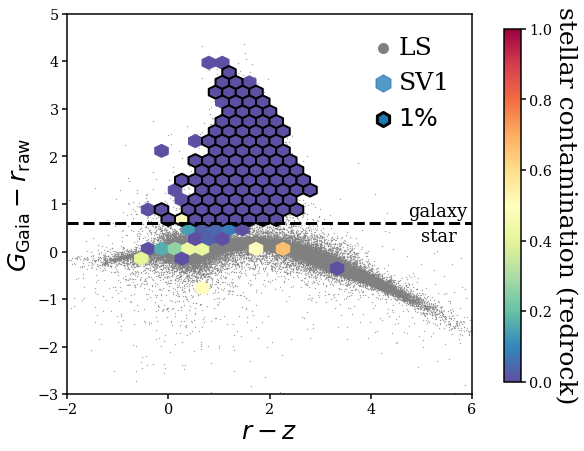

In [117]:
fig = plt.figure(figsize=(9,7))
sub = fig.add_subplot(111)

sub.scatter((gmag_S - zmag_S)[qm_S], G_rr_S[qm_S], c='gray', s=0.1, rasterized=True)
sub.scatter((gmag_N - zmag_N)[qm_N], G_rr_N[qm_N], c='gray', s=0.1, rasterized=True)
sub.scatter([], [], c='gray', s=100, label='LS')

hb = sub.hexbin((sv1_gmag - sv1_zmag), sv1_g_rr, C=(sv1_gals['RR_SPECTYPE'] == 'STAR').astype(float), 
                reduce_C_function=np.mean, extent=(-2, 6, -2, 5), gridsize=30, vmin=0., vmax=1, mincnt=2, cmap='Spectral_r')#, alpha=0.75)

hb = sub.hexbin((sv3_gmag - sv3_zmag)[sv3_brgt | sv3_fain], sv3_g_rr[sv3_brgt | sv3_fain], C=(sv3_gals['RR_SPECTYPE'] == 'STAR')[sv3_brgt | sv3_fain].astype(float), 
                edgecolors='k', linewidth=2., reduce_C_function=np.mean, extent=(-2, 6, -2, 5), gridsize=30, vmin=0., vmax=1, mincnt=2, cmap='Spectral_r')

#sub.scatter((sv3_gmag - sv3_rmag)[sv3_brgt | sv3_fain], sv3_g_rr[sv3_brgt | sv3_fain], c='r', s=1)
sub.text(5.9, 0.65, 'galaxy', ha='right', va='bottom', fontsize=18)
sub.text(5.7, 0.5, 'star', ha='right', va='top', fontsize=18)
sub.axhline(0.6, color='k', linestyle='--', linewidth=3)
sub.set_xlabel('$r - z$', fontsize=25)
sub.set_xlim(-2., 6.)
sub.set_xticks([-2., 0., 2., 4., 6.])
sub.set_ylabel(r'$G_{\rm Gaia} - r_{\rm raw}$', fontsize=25)
sub.set_ylim(-3., 5.)

sub.scatter([], [], marker='h', s=300, label='SV1', c='C0', alpha=0.75)
sub.scatter([], [], marker='h', s=200, label='$1\%$', linewidth=3, c='C0', edgecolor='k')

sub.legend(loc='upper right', fontsize=25, handletextpad=-0.4)

fig.subplots_adjust(wspace=0.1, right=0.75)

cbar_ax = fig.add_axes([0.8, 0.15, 0.025, 0.7])
cbar = fig.colorbar(hb, cax=cbar_ax)
cbar.ax.set_ylabel(r'stellar contamination (redrock)', labelpad=25, fontsize=25, rotation=270)
fig.savefig('figs/star_galaxy_redrock.pdf', bbox_inches='tight')